In [4]:
# My Packages
from modules.exact import trajectory
from modules.approximations import *
from modules.myconstants import *
from modules.converter import *
from scipy.optimize import curve_fit

In [5]:
# Standard packages
import numpy as np
from matplotlib import pyplot as plt, patches

In [13]:
#Graph Parameters
plt.rcParams['figure.figsize'] = 12,8
plt.rc('text', usetex=False)
plt.rcParams.update({'font.size': 18,
                     'legend.fontsize': 18})
plt.rcParams['font.family'] = 'serif'
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['lines.linewidth'] = 2.5

### Trajectory Computations
Takes a couple of seconds

In [7]:
R_Range = np.arange(2.1, 3.1, 0.1)                 # Range of radii (in gravitational units) we are simulating exactly
solution = [alpha_for_R(i) for i in R_Range]       #

In [8]:
# Reshaping the exact solutions into two separate physics lists
exactAlpha, exactPhi = [], []
for i in range(len(R_Range)):
    exactAlpha.append(solution[i][0])
    exactPhi.append(solution[i][1])

exactPhiDeg = np.rad2deg(exactPhi) # Converting phi angles to degrees for later convinience

In [30]:
np.savetxt('approxData/R_Range.csv', R_Range, delimiter=',')
np.savetxt('approxData/exactAlpha.csv', exactAlpha, delimiter=',')
np.savetxt('approxData/exactPhi.csv', psiDeg, delimiter=',')

In [29]:
'''
Following function extracts the best-fit poly coefficients for an R value which has been simulated exactly. 
Input - int index of the desired R in R_Range array
Output - coefficients for x^3, x^2, x^1 and constant term respectively
Note: following function is defined locally and cannot be used in other contexts

'''
def generate_coefficient_table(i):

    R = R_Range[i]
    alphaRange = exactAlpha[i]
    phiRange = exactPhi[i]
    phiRangeDeg = exactPhiDeg[i]
    belo = psi2alpha(phiRange, R)
    res = alphaRange - belo
    
    a, b, c, d = curve_fit(fourth_order_poly, phiRangeDeg, res)[0]

    return a, b, c, d

In [15]:
# Reshaping the list of best fit coeffecients in a convinient form
new_coefficients, a_list, b_list, c_list, d_list = [], [], [], [], []

for i in range(len(R_Range)):
    new_coefficients.append(generate_coefficient_table(i))
    a_list.append(new_coefficients[i][0])
    b_list.append(new_coefficients[i][1])
    c_list.append(new_coefficients[i][2])
    d_list.append(new_coefficients[i][3])
    
np.savetxt('approxData/a_coefficients.csv', a_list, delimiter=',')
np.savetxt('approxData/b_coefficients.csv', b_list, delimiter=',')
np.savetxt('approxData/c_coefficients.csv', c_list, delimiter=',')
np.savetxt('approxData/d_coefficients.csv', d_list, delimiter=',')

In [16]:
# The following twelve numbers completely characterize 
# the corrections required to improve Beloborodov approximation
A1, A2, A3, A4 = curve_fit(fourth_order_poly, R_Range, a_list)[0]
B1, B2, B3, B4 = curve_fit(fourth_order_poly, R_Range, b_list)[0]
C1, C2, C3, C4 = curve_fit(fourth_order_poly, R_Range, c_list)[0]
D1, D2, D3, D4 = curve_fit(fourth_order_poly, R_Range, d_list)[0]

np.savetxt('approxData/A.csv', [[A1, A2, A3, A4]], delimiter=',')
np.savetxt('approxData/B.csv', [[B1, B2, B3, B4]], delimiter=',')
np.savetxt('approxData/C.csv', [[C1, C2, C3, C4]], delimiter=',')
np.savetxt('approxData/D.csv', [[D1, D2, D3, D4]], delimiter=',')

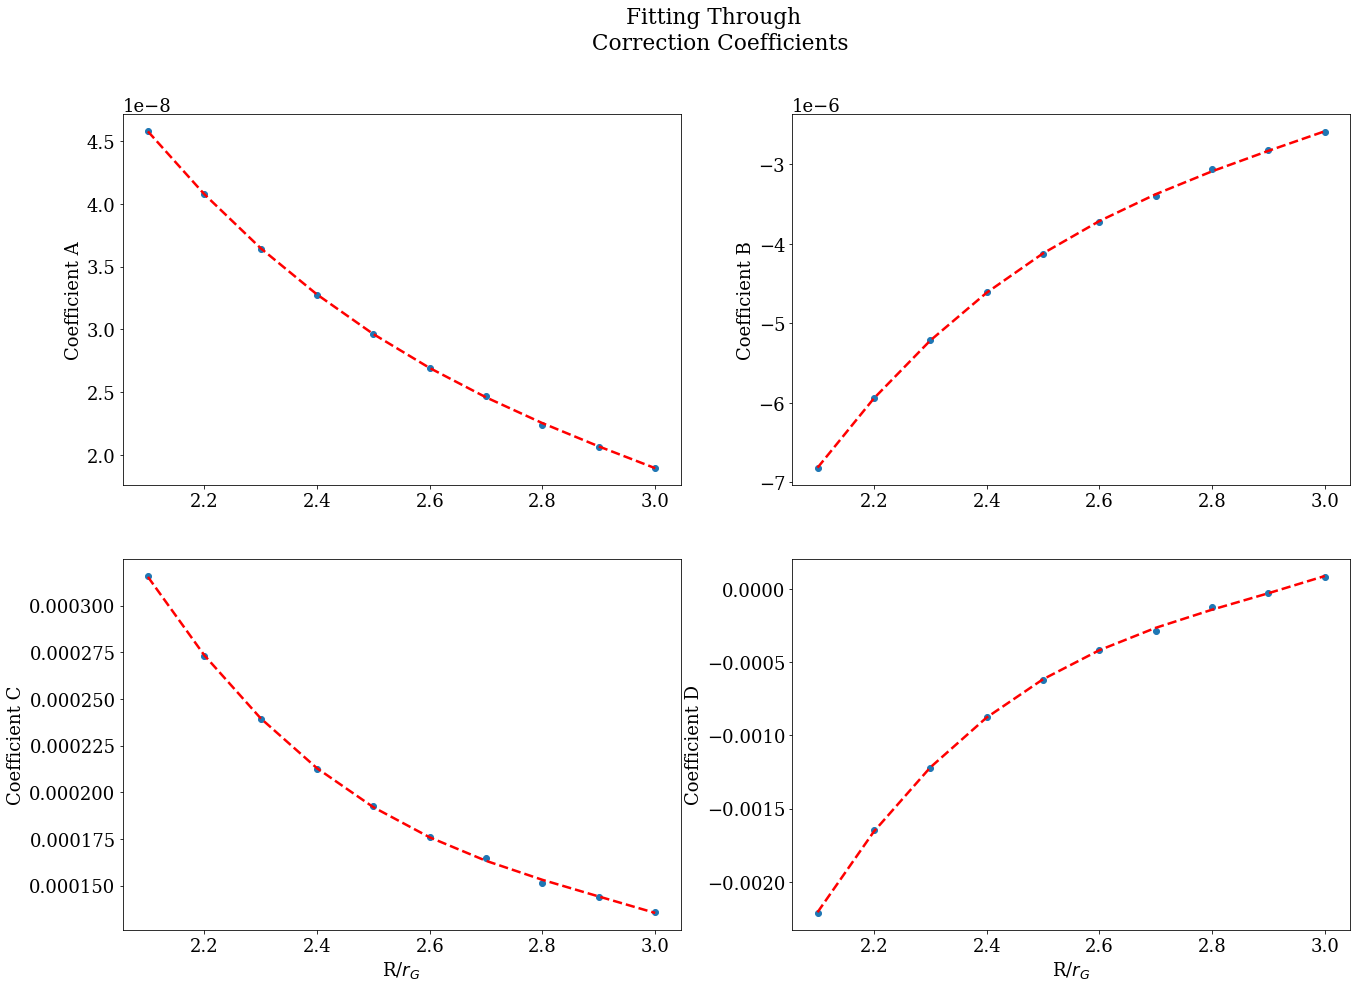

In [25]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(22,15))

fig.suptitle("Fitting Through \n Correction Coefficients")

ax1.scatter(R_Range, a_list)
ax1.plot(R_Range, fourth_order_poly(R_Range, A1, A2, A3, A4), 'r--')
ax1.set_ylabel("Coefficient A")

ax2.scatter(R_Range, b_list)
ax2.plot(R_Range, fourth_order_poly(R_Range, B1, B2, B3, B4), 'r--')
ax2.set_ylabel("Coefficient B")

ax3.scatter(R_Range, c_list)
ax3.plot(R_Range, fourth_order_poly(R_Range, C1, C2, C3, C4), 'r--')
ax3.set_xlabel(r"R/$r_G$")
ax3.set_ylabel("Coefficient C")

ax4.scatter(R_Range, d_list)
ax4.plot(R_Range, fourth_order_poly(R_Range, D1, D2, D3, D4), 'r--')
ax4.set_xlabel(r"R/$r_G$")
ax4.set_ylabel("Coefficient D")

plt.savefig("fig/CoefficientFit.png")

In [20]:
def extract_coefficients(R):
    a = fourth_order_poly(R, A1, A2, A3, A4)
    b = fourth_order_poly(R, B1, B2, B3, B4)
    c = fourth_order_poly(R, C1, C2, C3, C4)
    d = fourth_order_poly(R, D1, D2, D3, D4)
    
    return a, b, c, d

def fastApprox(psi, R, corr_coeff):
    
    a, b, c, d = corr_coeff
    residue = fourth_order_poly(np.rad2deg(psi), a, b, c, d)
    alpha = psi2alpha(psi, R) + residue
    
    return alpha, residue

In [38]:
def display_improvement(i):

    R = R_Range[i]
    exact = exactAlpha[i]
    psiRange, psiDeg = exactPhi[i], exactPhiDeg[i]
    corr_coeff = extract_coefficients(R) 
    belo,[newBelo, correction]  = psi2alpha(psiRange, R), fastApprox(psiRange, R, corr_coeff)
    res, newRes = (exact-belo), (exact - newBelo)

    beloErrPer = (exact-belo)/exact * 100
    newBeloErrPer = (exact-newBelo)/exact * 100
    
    fig, ((ax1, ax2), (ax3,ax4)) = plt.subplots(2,2, figsize=(22,15))
    print("Printing Results for R = ", R)
    fig.suptitle("Comparing Improved Beloborodov Approximation \n with Exact Results")

    ax1.scatter(psiDeg, exact, marker='x', label='Exact')
    ax1.scatter(psiDeg, belo, label='Beloborodov2003')
    ax1.scatter(psiDeg, newBelo, label='Modified Beloborodov2003')

    ax1.set_xlabel(r'Angle Between LOS and Radial Vector $\phi$')
    ax1.set_ylabel(r'Angle Between Radial vector and Ray $\alpha$')
    ax1.grid()
    ax1.legend()

    ax2.scatter(psiDeg, beloErrPer, marker='x', label='Beloborodov2003')
    ax2.scatter(psiDeg, newBeloErrPer, marker='x', label='Modified Beloborodov2003')
    ax2.legend()
    ax2.set_xlabel(r'Angle Between LOS and Radial Vector $\phi$')
    ax2.set_ylabel(r'Relative Error %')
    ax2.grid()
    plt.savefig('fig/BeloApproxCorrected.png')

    ax3.scatter(psiDeg, res, label=r'Residue $\alpha - \alpha_{Belo2003}$')
    ax3.plot(psiDeg,correction , 'r--')
    ax3.set_ylabel('Radians')
    ax3.legend()
    ax3.set_xlabel(r'Angle Between LOS and Radial Vector $\phi$')

    ax4.scatter(psiDeg, newRes, label=r'Residue $\alpha - \alpha_{modBelo2003}$')
    ax4.set_ylabel('Radians')
    ax4.legend()
    ax4.set_xlabel(r'Angle Between LOS and Radial Vector $\phi$')

Printing Results for R =  2.1


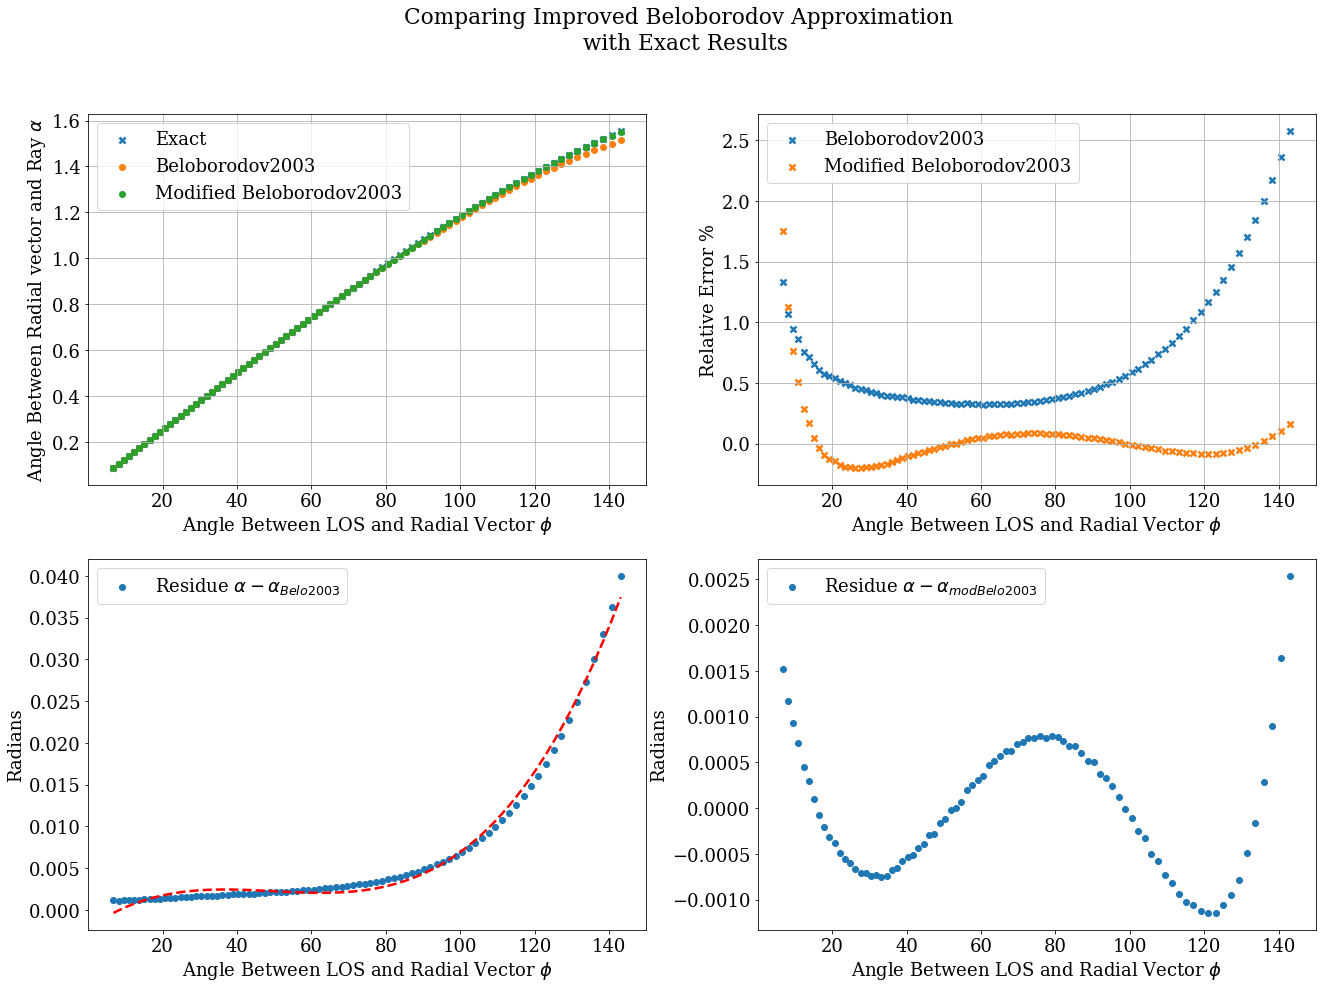

In [39]:
display_improvement(0)
plt.savefig("fig/generalModBeloR2-1.png")

Printing Results for R =  2.5000000000000004


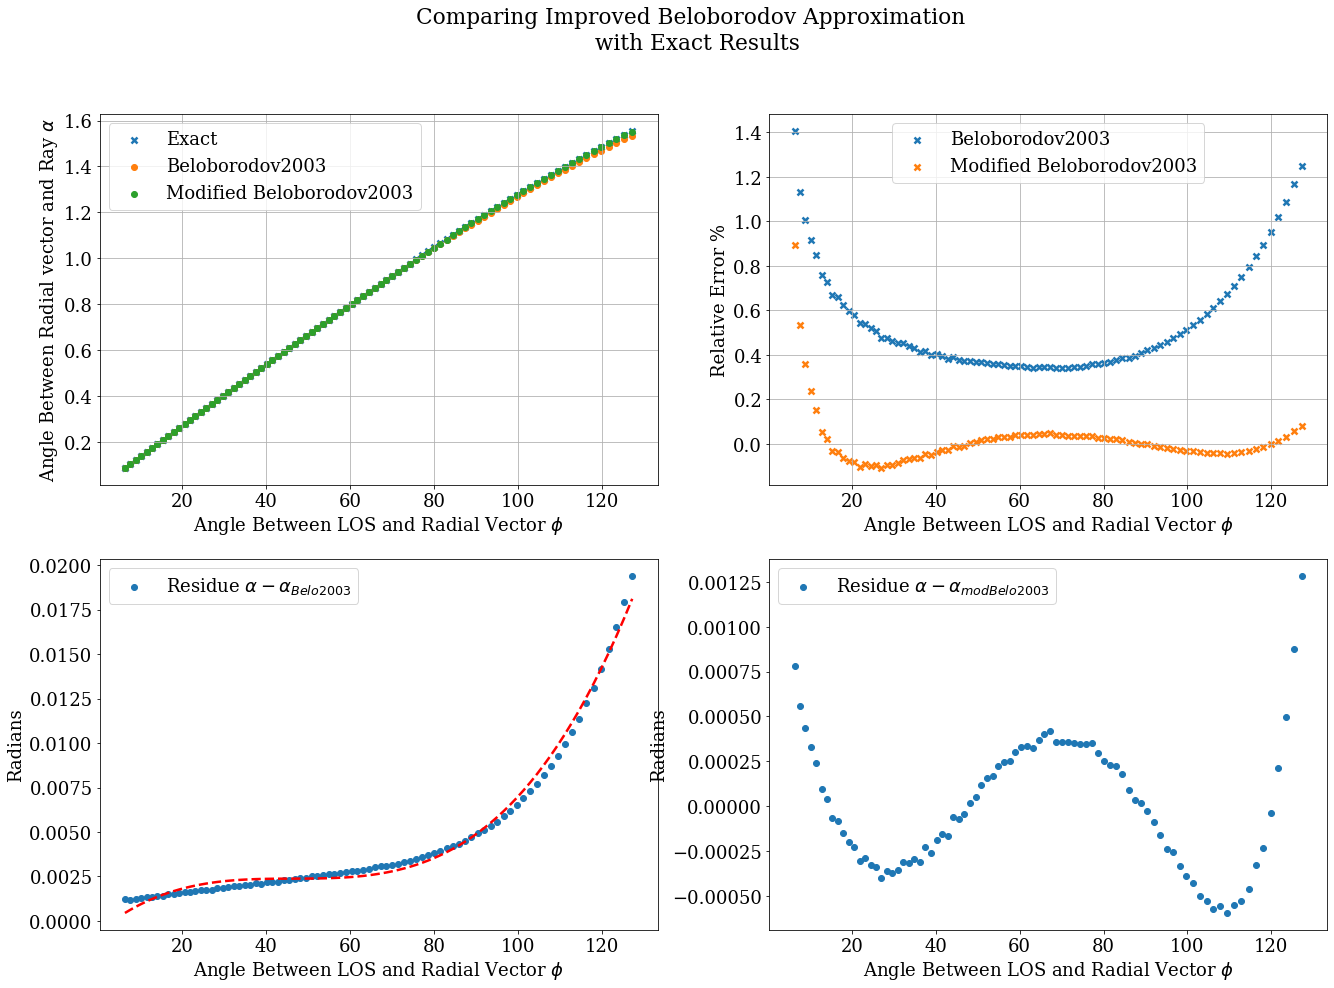

In [42]:
display_improvement(4)
plt.savefig("fig/generalModBeloR2-5.png")

Printing Results for R =  3.000000000000001


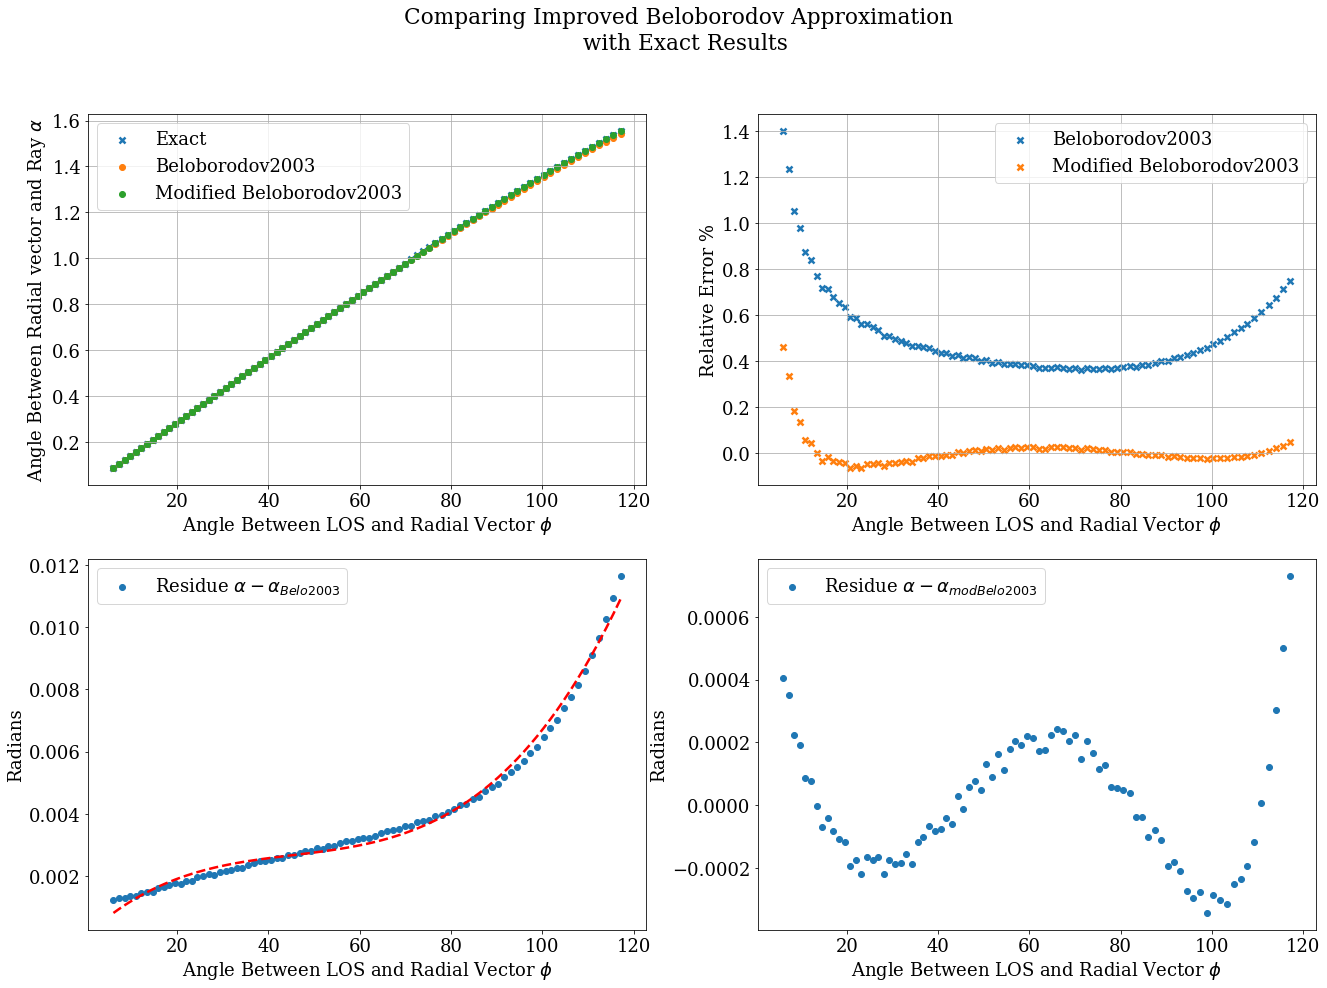

In [40]:
display_improvement(-1)
plt.savefig("fig/generalModBeloR3-0.png")